# Scattering within Memory Effect
![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR6j-9zKmcWBYV1tW6OxGmK5TvOGfrRbUauVA&s)

Fig.(a) is a single layer random phase and Fig.(b) is a double-layer random phase screen. The double-layer random phase screen can be used to simulate the isotropic and uniformly thick thin scattering medium.

In [1]:
import pyoptics
import matplotlib.pyplot as plt
import numpy as np

## Simulate a double-layer random phase screen scattering

In [2]:
random_pha = np.angle(np.fft.fft2(np.random.rand(512, 512)))
wavelength =532e-9
N = 512
dx=1e-5
L = N*dx
sourceLayer = pyoptics.GaussianBeamLayer(L=L, N=N, wavelength=wavelength, radius=100e-5, angleX=0,
                                         angleY=0)
aperture1 = pyoptics.ApertureLayer(L=L, N=N, wavelength=wavelength, radius=30e-5)
scatter1 = pyoptics.CustomLayer(L=L, N=N, wavelength=wavelength, pha=random_pha)
scatter2 = pyoptics.CustomLayer(L=L, N=N, wavelength=wavelength, pha=random_pha)
aperture2 = pyoptics.ApertureLayer(L=L, N=N, wavelength=wavelength, radius=30e-5)

Layers_list = [[sourceLayer,scatter1, aperture1],[scatter2,aperture2]]

Distance_list = [1e-3,3e-2]

OMEsystem = pyoptics.OpticsSystem(Layers_list, Distance_list)
z = sum(Distance_list)
# z(m): propagation distance along Z axis
z_step = 1e-4
# z_step: simulation step of Z axis

# simulation of light filed propagation along Z axis
number_of_z_step = round(z / z_step)

field_along_z = OMEsystem.field_propagation_along_z(z, z_step)
YZ_field = np.abs(field_along_z[:, 512 // 2])
z_total = np.arange(0, number_of_z_step) * z_step

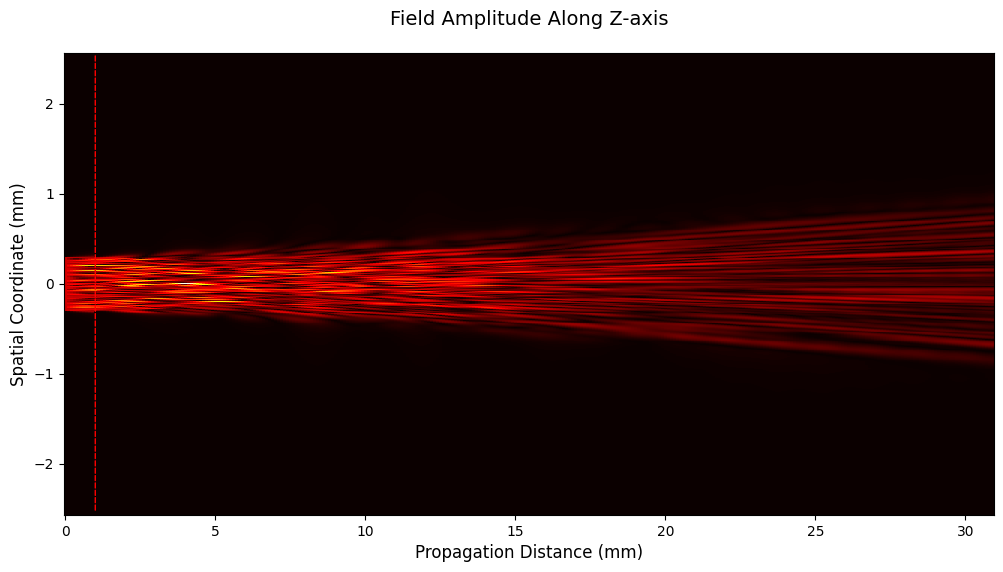

In [3]:
fig = plt.figure(figsize=(12, 6))

plt.pcolormesh(z_total * 10 ** 3, sourceLayer.x * 10 ** 6/(10**3), YZ_field.T, cmap='hot')
plt.xlabel('Propagation Distance (mm)', fontsize=12)
plt.ylabel('Spatial Coordinate (mm)', fontsize=12)
plt.title('Field Amplitude Along Z-axis', fontsize=14, pad=20)

for i in range(len(Layers_list)-1):
    plt.annotate('', xy=(sum(Distance_list[0:i+1])*10**3, -L*(10**3)/2), xytext=(sum(Distance_list[0:i+1])*10**3, L*(10**3)/2),
                  arrowprops=dict(arrowstyle='-', linestyle='--', color='red'))
plt.show()

## Simulate incoherent imaging through scattering medium with memory effect
![image.png](https://s2.loli.net/2025/04/08/l1WVT6ANPuHD3Sg.png)

[Simulation Reference Link](https://github.com/HertzGreetings/Simulation-Script-for-Researchers)

In [4]:
# simulation parameters setting
N = 800
D = 200
d1 = 10e-3
wavelength = 633e-6
k = 2 * np.pi / wavelength

xlist = np.arange(-N / 2, N / 2) * d1
ylist = np.arange(-N / 2, N / 2) * d1
x, y = np.meshgrid(xlist, ylist)

df = 1 / (N * d1)
fxlist = np.arange(-N / 2, N / 2) * df
fylist = np.arange(-N / 2, N / 2) * df
fx1, fy1 = np.meshgrid(fxlist, fylist)

In [5]:
# define Fast Fourier Transform for optical simulation
from scipy.fft import fft2, ifft2, fftshift, ifftshift
def ft2(x, delta):
    return fftshift(fft2(ifftshift(x))) * delta ** 2

def ift2(x, delta_f):
    return fftshift(ifft2(ifftshift(x))) * (N * delta_f) ** 2

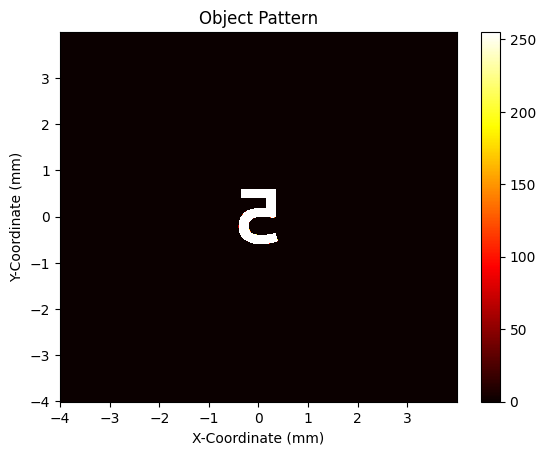

In [6]:
# load image pattern
from PIL import Image
from scipy.ndimage import rotate
from skimage.transform import resize
Obj1 = np.zeros((N, N))
imageA = np.array(Image.open('../assets/5.bmp').convert('L'))

imageA = resize(imageA, (D, D), order=0)
imageA = rotate(imageA, 180)

px, py = imageA.shape
px_start = (N - px) // 2
py_start = (N - py) // 2
Obj1[px_start:px_start + px, py_start:py_start + py] = imageA

plt.pcolormesh(x, y, Obj1, cmap='hot')

plt.title('Object Pattern')
plt.xlabel('X-Coordinate (mm)')
plt.ylabel('Y-Coordinate (mm)')
plt.colorbar()
plt.show()

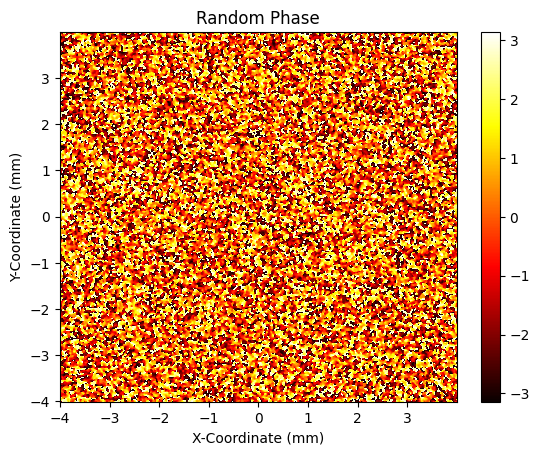

In [7]:
# generate random phase on the scattering medium
np.random.seed(42)
Cn = np.random.randn(N, N) + 1j * np.random.randn(N, N)
RG = 12
gaussian_filter = np.exp(-(fx1 ** 2 + fy1 ** 2) / RG ** 2)
Random_Phase = np.exp(1j * np.angle(ft2(Cn * gaussian_filter, 1)))
plt.pcolormesh(x, y, np.angle(Random_Phase), cmap='hot')
plt.title('Random Phase')
plt.xlabel('X-Coordinate (mm)')
plt.ylabel('Y-Coordinate (mm)')
plt.colorbar()
plt.show()

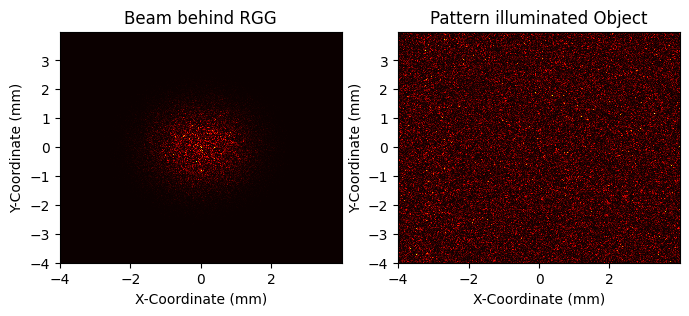

In [8]:
# simulate pseudo-thermal light
coh = 15
pA = np.exp(-(fx1 ** 2 + fy1 ** 2) / coh ** 2)
Rn = np.sqrt(pA) * (1 / np.sqrt(2)) * (np.random.randn(N, N) + 1j * np.random.randn(N, N))
E1 = ft2(Rn, df ** 2)

fig = plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.pcolormesh(x,y,np.abs(Rn)**2,cmap='hot')
plt.title("Beam behind RGG")
plt.xlabel('X-Coordinate (mm)')
plt.ylabel('Y-Coordinate (mm)')

plt.subplot(1, 2, 2)
plt.pcolormesh(x,y,np.abs(E1)**2,cmap='hot')
plt.title("Pattern illuminated Object")
plt.xlabel('X-Coordinate (mm)')
plt.ylabel('Y-Coordinate (mm)')
plt.show()

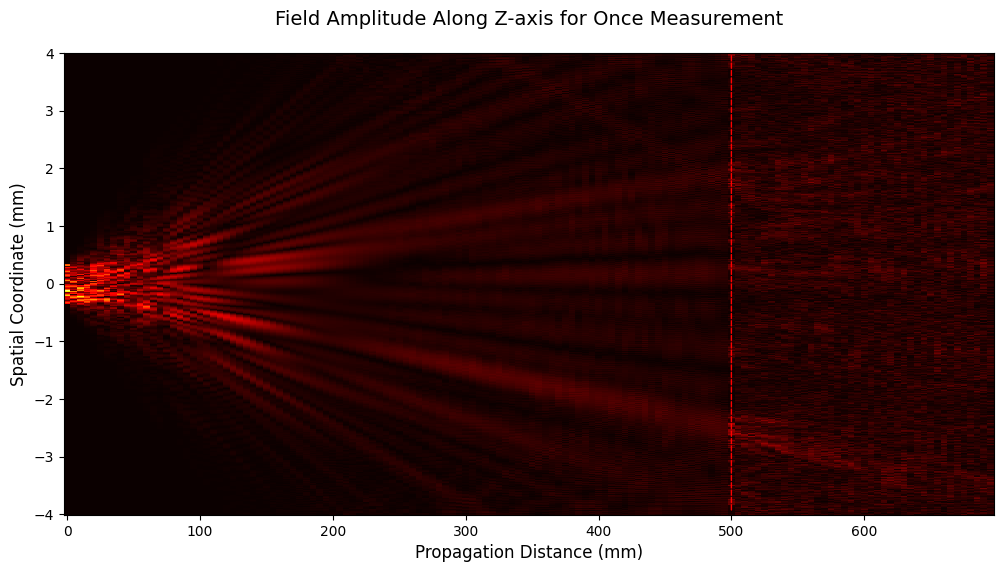

In [9]:
scatter = pyoptics.CustomLayer(L=N*d1, N=N, wavelength=wavelength, pha=Random_Phase)
I=np.zeros((N,N))

# Simulate pseudo-thermal light source

for i in range(200):

    Rn = np.sqrt(pA) * (1 / np.sqrt(2)) * (np.random.randn(N, N) + 1j * np.random.randn(N, N))
    E1 = ft2(Rn, df ** 2)

    u1 = E1 * Obj1
    object = pyoptics.CustomLayer(L=N*d1,N=N,wavelength=wavelength,mag=np.abs(u1),pha=np.angle(u1))
    Layers_list = [[object],[scatter]]
    Distance_list = [500,200]

    OMEsystem = pyoptics.OpticsSystem(Layers_list, Distance_list)
    z = sum(Distance_list)
    I = I+ np.abs(OMEsystem.field_propagation(z))**2

z_step = 5
number_of_z_step = round(z / z_step)
z_total = np.arange(0, number_of_z_step) * z_step

fig = plt.figure(figsize=(12, 6))

field_along_z = OMEsystem.field_propagation_along_z(z, z_step)
YZ_field = np.abs(field_along_z[:, N // 2])

plt.pcolormesh(z_total, object.x, YZ_field.T, cmap='hot')
plt.xlabel('Propagation Distance (mm)', fontsize=12)
plt.ylabel('Spatial Coordinate (mm)', fontsize=12)
plt.title('Field Amplitude Along Z-axis for Once Measurement', fontsize=14, pad=20)

for i in range(len(Layers_list)-1):
    plt.annotate('', xy=(sum(Distance_list[0:i+1]), -N*d1/2), xytext=(sum(Distance_list[0:i+1]), N*d1/2),
                  arrowprops=dict(arrowstyle='-', linestyle='--', color='red'))
plt.show()

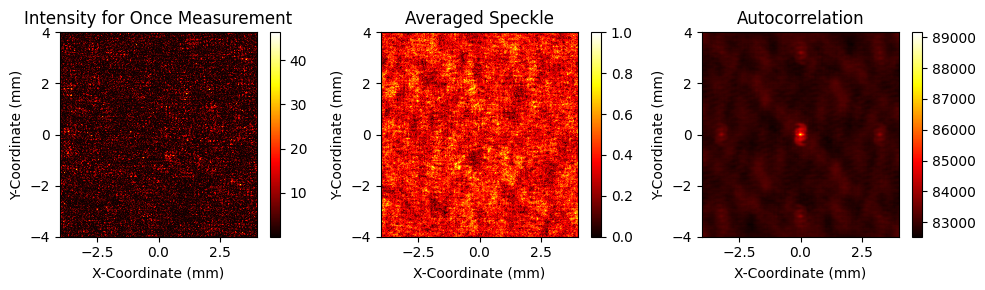

In [10]:
I=I-np.min(I)
I=I/np.max(I)

fig = plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plt.pcolormesh(object.x, object.y, np.abs(field_along_z[-1,:])**2, cmap='hot')
plt.colorbar()
plt.title('Intensity for Once Measurement')
plt.xlabel('X-Coordinate (mm)')
plt.ylabel('Y-Coordinate (mm)')

plt.subplot(1, 3, 2)
plt.pcolormesh(object.x, object.y, I, cmap='hot')
plt.colorbar()
plt.title('Averaged Speckle')
plt.xlabel('X-Coordinate (mm)')
plt.ylabel('Y-Coordinate (mm)')

ac = np.real(ifftshift(ifft2((np.abs(fft2(I))**2))))
plt.subplot(1, 3, 3)
plt.pcolormesh(object.x, object.y, ac, cmap='hot')
plt.colorbar()
plt.title('Autocorrelation')
plt.xlabel('X-Coordinate (mm)')
plt.ylabel('Y-Coordinate (mm)')

plt.tight_layout()
plt.show()

The averaged speckles is obtained from 200 times coherent measurements of intensity distribution. According to memory effect and imaging model, the imaging process can be simplified as an incoherent imaging system:
$$
I(x,y)=O(x,y)\ast S(x,y)
$$
where $I(x,y)$ is the intensity distribution on the observation plane, $O$ and $S$ are the Object Radiance and Point Spread Function, respectively. Ignoring $S\star S$, the autocorrelation of $I$ is similar to the autocorrelation of $O$.
$$
I\star I=(O\star O)\ast(S\star S).
$$
It means that Fourier amplitude of object can be estimated from the Fourier amplitude of the incoherent speckle.